# Chapter 7 앙상블 학습과 랜덤 포레스트

## 7.1 투표 기반 분류기

**직접 투표 분류기**
- 많은 수의 classifier를 훈련시킨다
- 각 classifier의 output에서 제일 많이 나온 것을 최종 output으로 결정

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [3]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [5]:
X, y = make_moons(n_samples=1000, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.835
RandomForestClassifier 0.885
SVC 0.89
VotingClassifier 0.89


**간접 투표 방식**
- 모든 분류기가 확률 예측이 가능하면 예측 확률을 평균내어 가장 높은 클래스를 예측 가능
- voting="hard"를 voting="soft"로 바꾸면 된다.

## 7.2 배깅과 페이스팅

훈련 세트의 서브셋을 무작위로 구성하여 여러개의 분류기를 학습시킨다.
- 배깅: 훈련 세트에서 중복을 허용하여 샘플링
- 페이스팅: 중복을 허용하지 않고 샘플링

- 개별 예측기는 크게 편향되어 있지만,
- 수집함수를 통과하면 편향과 분산이 모두 감소한다.

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)

In [11]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def plot_bagging(clf, X, y, axis):
    plt.plot(X[:,0][y==0], X[:,1][y==0], "g^")
    plt.plot(X[:,0][y==1], X[:,1][y==1], "b.")
    plt.axis(axis)
    
    x0s=np.linspace(axis[0], axis[1], 100)
    x1s=np.linspace(axis[2], axis[3], 100)
    
    X0, X1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[X0.ravel(), X1.ravel()]
    
    y_grid = clf.predict(X_grid).reshape(X0.shape)
    plt.contourf(X0, X1, y_grid)

In [ ]:
plot_bagging(bag_clf, X, y, [-2, 2, -1.5, 1.5])

앙상블의 예측이 결정 트리 하나의 예측에 비하여 일반화가 훨씬 잘된다.   
앙상블은 비슷한 편향에서 더 작은 분산을 만든다.   
부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성 증가시킴 -> 배깅이 페이스팅보다 편향이 좀 더 놓음.  
다양성이 추가될 수록 예측기들의 상관관계가 줄어듦 -> 배깅의 분산이 페이스팅보다 작음   
일반적으로 배깅이 더 좋은 모델을 만든다

**oob 평가**   
bootstrap을 하면 한 예측기에 훈련 샘플의 63% 정도만 사용된다.   
나머지 사용되지 않은 훈련 샘플들을 oob샘플 이라고 부른다.   
oob 샘플을 이용하여 각 예측기의 성능을 평가할 수 있다.   
앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)

In [16]:
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.86

## 7.3 랜덤 패치와 랜덤 서브스페이스

- 랜덤 패치 방식: 훈련 샘플과 훈련 특성을 모두 샘플링
- 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용, 특성만 샘플링
- bootstrap_features, max_features로 설정

## 7.4 랜덤 포레스트

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# 500개의 트리로 이루어진 randomforestclassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [21]:
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.895

In [22]:
# baggingclassifier를 이용해 위의 rnd_clf와 비슷하게 만들기

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500
)

**엑스트라 트리(익스트림 랜덤 트리)**
랜덤 포레스트는 수많은 트리가 존재하므로, 이 트리들에 다양성을 부여해야 한다.   
이를 위해 노드 분할 시, 전체 특성에서 최적값을 찾는 것이 아니라, 몇 가지 랜덤한 특성의 서브셋만을 사용한다.   
또한 이 특성들에 대해서도 최적의 임곗값을 찾지 않고, 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다.   
이 과정에서 편향이 늘어나고 분산이 줄어든다.
- 엑스트라 트리를 만들기 위해서는 ExtraTreesClassifier를 사용

**특성 중요도**
어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도는 측정

In [23]:
from sklearn.datasets import load_iris

In [24]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [25]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10663491043991462
sepal width (cm) 0.026429176808887185
petal length (cm) 0.4308382131140446
petal width (cm) 0.4360976996371536


## 7.5 부스팅

> 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

**에이다 부스트(adaptive boosting)**
> 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높인다.
- 첫 번째 분류기를 훈련세트에서 훈련시키고 예측을 만든다.
- 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
- 두 번째 분류기는 업데이트 된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
- 위 과정 반복

**에이다 부스트 훈련 알고리즘**
1. 각 샘플의 가중치 $w^{(i)}$는 초기에 $\dfrac{1}{m}$로 초기화
2. j번째 예측기의 가중치가 적용된 에러율:
$r_j = \dfrac{\sum_{i=1, \hat{y}_j^{(i)}\neq y^{(i)}}^mw^{(i)}}{\sum_{i=1}^mw^{(i)}}$
3. 예측기 가중치: $\alpha_j = \eta log\dfrac{1-r_j}{r_j}$
4. 가중치 업데이트 규칙: $w^{(i)}\leftarrow \begin{cases}
w^{(i)}, \ if \ \hat{y}_j^{(i)}=y^{(i)} \\
w^{(i)}exp(\alpha_j), \ if \ \hat{y}_j^{(i)}\neq y^{(i)}
\end{cases}$
5. 이후 모든 샘플의 가중치 정규화

**에이다 부스트 예측 알고리즘**   
모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다.   
$\hat{y}(x) = argmax_k \sum_{j=1, \hat{y}_j(x)=k}^N\alpha_j$

In [26]:
from sklearn.ensemble import AdaBoostClassifier

In [27]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)

In [28]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

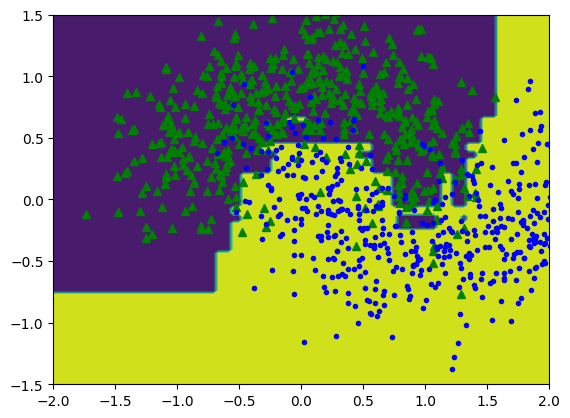

In [29]:
plot_bagging(ada_clf, X, y, [-2, 2, -1.5, 1.5])

**그레디언트 부스팅**   
이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킨다.

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05*np.random.randn(100)

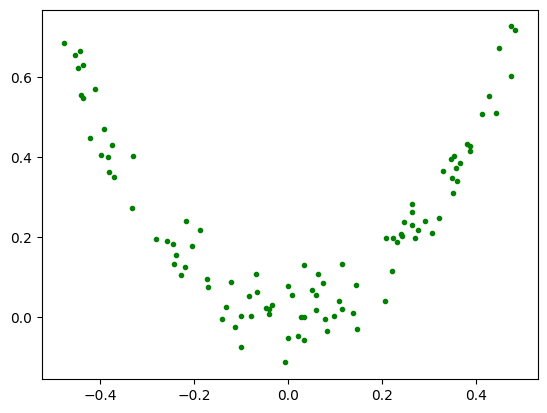

In [32]:
plt.plot(X, y, 'g.')

In [33]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [34]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [35]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [36]:
X_new = np.array([[0.8]])

In [37]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([0.69642489])

In [39]:
def plot_regression(regs, X, y, axis):
    X_grid = np.linspace(axis[0], axis[1], 300).reshape(-1, 1)
    y_pred = sum(tree.predict(X_grid) for tree in regs)
    plt.plot(X, y, 'b.')
    plt.plot(X_grid, y_pred, 'g-')
    plt.axis(axis)
    plt.show()

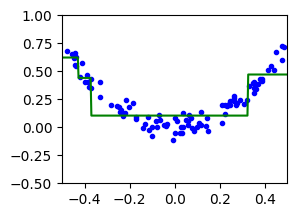

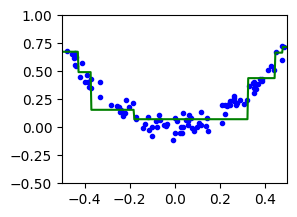

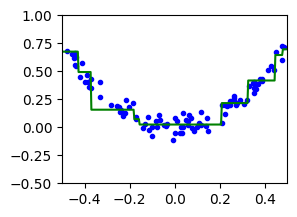

In [40]:
axis = [-0.5, 0.5, -0.5, 1]
plt.subplot(2, 2, 1)
plot_regression([tree_reg1], X, y, axis)
plt.subplot(2, 2, 2)
plot_regression([tree_reg1,tree_reg2], X, y, axis)
plt.subplot(2, 2, 3)
plot_regression([tree_reg1, tree_reg2, tree_reg3], X, y, axis)

learning_rate 매개변수가 각 트리의 기여 정도를 조절한다. learning_rate가 낮으면 앙상블을 훈련세트에 학습시키기 위해 많은 트리가 필요하지만, 일반적으로 예측의 성능은 좋아진다. 이를 축소라는 규제 방법으로 부른다.

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [42]:
grbt1 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
grbt2 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1)

In [43]:
grbt1.fit(X, y)
grbt2.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200)

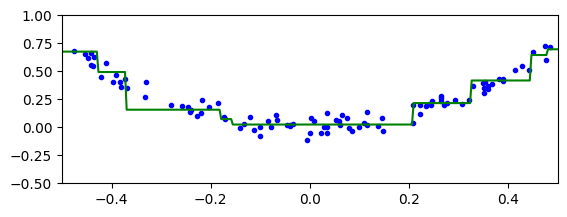

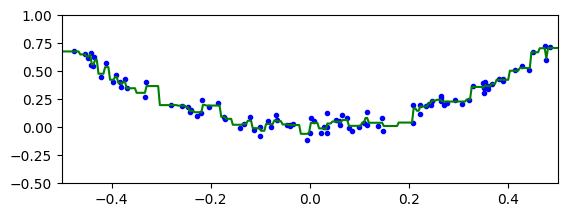

In [44]:
plt.subplot(2, 1, 1)
plot_regression([grbt1], X, y, axis) # 과소적합
plt.subplot(2, 1, 2)
plot_regression([grbt2], X, y, axis) # 과대적합

In [45]:
#최적의 트리 수 찾기

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [47]:
grbt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
grbt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [48]:
# staged_predict(): 훈련의 각 단계(트리가 1개일때, 2개일때,.. 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환한다.
errors = [mean_squared_error(y_val, y_pred) for y_pred in grbt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

In [49]:
grbt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
grbt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=44)

In [50]:
y_pred_best = grbt_best.predict(X)

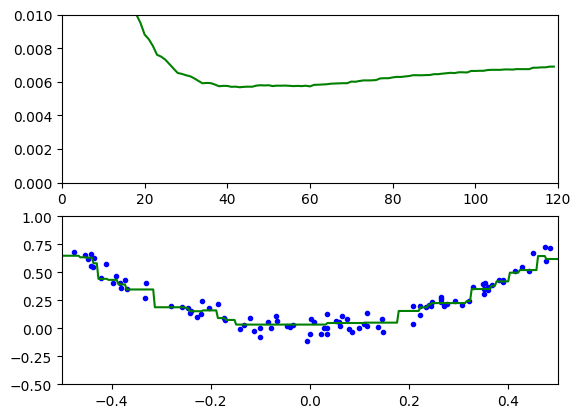

In [51]:
plt.subplot(2, 1, 1)
plt.plot(range(len(errors)), errors, 'g-')
plt.axis([0, len(errors), 0, 0.01])
plt.subplot(2, 1, 2)
plot_regression([grbt_best], X, y, axis)
plt.show()

In [52]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 조기종료

In [53]:
gbrt.n_estimators

49

**확률적 그레디언트 부스팅**
- 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정
- 편향이 높아지는 대신 분산이 낮아짐
- subsample 매개변수를 사용하여 지정 가능

In [54]:
import xgboost

In [55]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

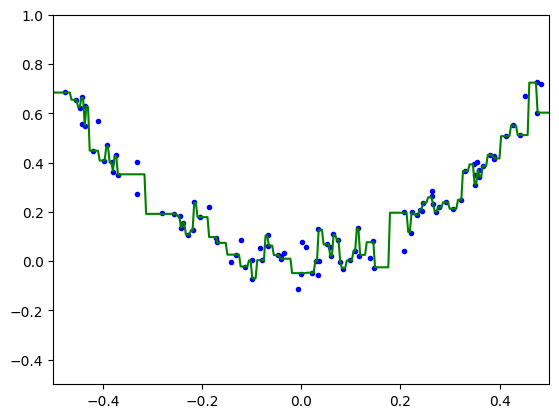

In [56]:
plot_regression([xgb_reg], X, y, axis)

[0]	validation_0-rmse:0.27696
[1]	validation_0-rmse:0.20455
[2]	validation_0-rmse:0.15652
[3]	validation_0-rmse:0.12415
[4]	validation_0-rmse:0.10462
[5]	validation_0-rmse:0.09428
[6]	validation_0-rmse:0.08829
[7]	validation_0-rmse:0.08660
[8]	validation_0-rmse:0.08449
[9]	validation_0-rmse:0.08302
[10]	validation_0-rmse:0.08380
[11]	validation_0-rmse:0.08297
[12]	validation_0-rmse:0.08422
[13]	validation_0-rmse:0.08430
[14]	validation_0-rmse:0.08540
[15]	validation_0-rmse:0.08601
[16]	validation_0-rmse:0.08617
[17]	validation_0-rmse:0.08719
[18]	validation_0-rmse:0.08744
[19]	validation_0-rmse:0.08795
[20]	validation_0-rmse:0.08881
[21]	validation_0-rmse:0.08957
[22]	validation_0-rmse:0.09005
[23]	validation_0-rmse:0.09032
[24]	validation_0-rmse:0.09071
[25]	validation_0-rmse:0.09088
[26]	validation_0-rmse:0.09102
[27]	validation_0-rmse:0.09118
[28]	validation_0-rmse:0.09128
[29]	validation_0-rmse:0.09173
[30]	validation_0-rmse:0.09174
[31]	validation_0-rmse:0.09214
[32]	validation_0-

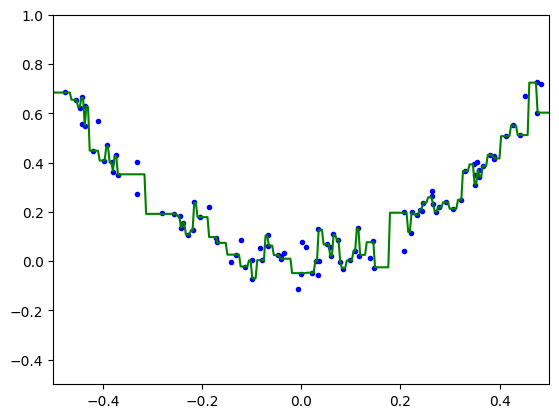

In [57]:
xgb_reg_early = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
plot_regression([xgb_reg], X, y, axis)

## 7.6 스태킹

**스태킹**   
앙상블에 속한 모든 예측기의 예측을 취합하는 모델(블렌더)을 훈련시킨다.

**스태킹의 방법**
- 훈련 세트를 두 개의 서브셋으로 나눈다. (두 번쨰 세트를 홀드 아웃 세트라고 한다.)
- 첫 번째 서브셋을 사용해 첫번째 레이어의 예측을 훈련시킨다.
- 첫 번째 레이어의 예측기를 사용해 홀드 아웃 세트에 대한 예측을 만든다.
- 홀드 아웃 세트의 예측값과 타깃값을 활용한 새로운 훈련 세트를 만든다.
- 새 훈련 세트로 블렌더를 훈련시킨다.

## 연습문제

In [60]:
from sklearn.datasets import fetch_openml

In [62]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [67]:
X, y = mnist['data'], mnist['target'].astype(np.uint8)

In [69]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=10000)

In [70]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [78]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [79]:
classifiers = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for clf in classifiers:
    print('Training the', clf)
    clf.fit(X_train, y_train)

[clf.score(X_val, y_val) for clf in classifiers]

Training the RandomForestClassifier(n_jobs=-1, random_state=42)
Training the RandomForestClassifier(n_jobs=-1, random_state=42)
Training the ExtraTreesClassifier(n_jobs=-1, random_state=42)
Training the ExtraTreesClassifier(n_jobs=-1, random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)
Training the MLPClassifier(random_state=42)


[0.9682, 0.9738, 0.8543, 0.9605]

[0.9682, 0.9738, 0.8543, 0.9605]

In [80]:
named_classifiers = [
    ("random_forest_clf", random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf)
]

voting_clf = VotingClassifier(named_classifiers, n_jobs=-1)

In [67]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))],
                 n_jobs=-1)

In [68]:
voting_clf.score(X_val, y_val)

0.9725

In [72]:
del voting_clf.estimators_[2]

In [73]:
voting_clf.score(X_val, y_val)

0.9707

In [74]:
voting_clf.voting = 'soft'
voting_clf.score(X_val, y_val)

0.9707

In [76]:
X_val_predictions = np.empty((len(X_val), len(classifiers)), dtype=np.float32)

for index, clf in enumerate(classifiers):
    X_val_predictions[:, index] = clf.predict(X_val)

In [77]:
X_val_predictions

array([[8., 8., 8., 8.],
       [8., 8., 8., 8.],
       [8., 8., 5., 8.],
       ...,
       [2., 2., 2., 2.],
       [6., 6., 6., 6.],
       [8., 8., 8., 8.]], dtype=float32)

In [78]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True)

In [79]:
rnd_forest_blender.oob_score_

0.9705

In [80]:
X_test_predictions = np.empty((len(X_test), len(classifiers)), dtype=np.float32)

for index, clf in enumerate(classifiers):
    X_test_predictions[:, index] = clf.predict(X_test)

In [84]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [85]:
accuracy_score(y_test, y_pred)

0.9949